# Cercador model òptim de DNN 

In [1]:
import numpy as np
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import plotly.graph_objects as go
import math
import seaborn as sns
from sklearn.metrics import mean_squared_error
from time import time

np.random.seed(2)
tf.random.set_seed(2)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, RepeatVector, TimeDistributed
from tensorflow.keras import backend

C:\Users\dj_kr\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Càrrega de les dades

In [2]:
df = pd.read_csv('data/SentDATA.csv')

df.reset_index(inplace=True)
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')

## Anàlisis estadístic

## Transformació de dades

In [3]:
columns = ['PM1','PM25','PM10','PM1ATM','PM25ATM','PM10ATM']

df1 = df.copy();

df1 = df1.rename(columns={"PM 1":"PM1","PM 2.5":"PM25","PM 10":"PM10","PM 1 ATM":"PM1ATM","PM 2.5 ATM":"PM25ATM","PM 10 ATM":"PM10ATM"})

df1['PM1'] = df['PM 1'].astype(np.float32)
df1['PM25'] = df['PM 2.5'].astype(np.float32)
df1['PM10'] = df['PM 10'].astype(np.float32)
df1['PM1ATM'] = df['PM 1 ATM'].astype(np.float32)
df1['PM25ATM'] = df['PM 2.5 ATM'].astype(np.float32)
df1['PM10ATM'] = df['PM 10 ATM'].astype(np.float32)

In [4]:
df2 = df1.copy()

## Crear dades d'entrenament i de test

In [5]:
train_size = int(len(df2) * 0.8)
test_size = len(df2) - train_size
train, test = df2.iloc[0:train_size], df2.iloc[train_size:len(df2)]
train.shape, test.shape

((3991, 7), (998, 7))

## Normalitzar les dades d'entrenament

In [6]:
#Standardize the data
for col in columns:
    scaler = MinMaxScaler()
    train[col] = scaler.fit_transform(train[[col]])


<ipython-input-6-c8a1383fd1da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scaler.fit_transform(train[[col]])
<ipython-input-6-c8a1383fd1da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scaler.fit_transform(train[[col]])
<ipython-input-6-c8a1383fd1da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

## Crear finestra de temps PM 2.5

In [7]:
TIME_STEPS=144 #6 registres hora x 24h x 3 --> equival a una finestra d'un dia

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train1h, y_train1h = create_sequences(train[[columns[1]]], train[columns[1]], 6) #1 hour

X_train3h, y_train3h = create_sequences(train[[columns[1]]], train[columns[1]], 18) #3 hours

X_train6h, y_train6h = create_sequences(train[[columns[1]]], train[columns[1]], 36) #6 hours

X_train12h, y_train12h = create_sequences(train[[columns[1]]], train[columns[1]], 72) #12 hours

X_train1d, y_train1d = create_sequences(train[[columns[1]]], train[columns[1]], 144) #1 day

X_train3d, y_train3d = create_sequences(train[[columns[1]]], train[columns[1]], 432) #3 days

X_train7d, y_train7d = create_sequences(train[[columns[1]]], train[columns[1]], 1008) #7 days
#X_test, y_test = create_sequences(test[[columns[1]]], test[columns[1]])

print(f'X_train1h shape: {X_train1d.shape}')
print(f'X_train3d shape: {X_train3h.shape}')
print(f'X_train6h shape: {X_train6h.shape}')
print(f'X_train12h shape: {X_train12h.shape}')
print(f'X_train1d shape: {X_train1d.shape}')
print(f'X_train3d shape: {X_train3d.shape}')
print(f'X_train7d shape: {X_train7d.shape}')

X_train1h shape: (3847, 144, 1)
X_train3d shape: (3973, 18, 1)
X_train6h shape: (3955, 36, 1)
X_train12h shape: (3919, 72, 1)
X_train1d shape: (3847, 144, 1)
X_train3d shape: (3559, 432, 1)
X_train7d shape: (2983, 1008, 1)


In [8]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Square Error: {:.4f}'.format(mse))
    print('')
    return mae,rmse,mse

## Cerca dels models òptims

###########################

MODEL:  DNN
sequence:  1h
units:  97
dropout1:  0.795696407994891
optimizer: adam
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6, 97)             194       
_________________________________________________________________
dense_7 (Dense)              (None, 6, 16)             1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 16)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 6, 1)              17        
Total params: 1,779
Trainable params: 1,779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/98
84/84 [==============================] - 0s 4ms/step - loss

84/84 [==============================] - 0s 2ms/step - loss: 0.0234 - val_loss: 0.0139
Epoch 71/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0134
Epoch 72/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0235 - val_loss: 0.0140
Epoch 73/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0134
Epoch 74/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0137
Epoch 75/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0138
Epoch 76/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0136
Epoch 77/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0233 - val_loss: 0.0135
Epoch 78/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0156
Epoch 79/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0232 - val_loss: 0.0129
Epoch 80/98
84/84 [===

139/139 [==============================] - 0s 2ms/step - loss: 0.0247 - val_loss: 0.0142
Epoch 42/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0249 - val_loss: 0.0141
Epoch 43/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0144
Epoch 44/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0142
Epoch 45/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0248 - val_loss: 0.0140
Epoch 46/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0142
Epoch 47/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0244 - val_loss: 0.0140
Epoch 48/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0140
Epoch 49/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0242 - val_loss: 0.0141
Epoch 50/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0241 - val_loss: 0.0139
Ep

84/84 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0153
Epoch 26/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0165
Epoch 27/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0150
Epoch 28/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0161
Epoch 29/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0150
Epoch 30/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0163
Epoch 31/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0155
Epoch 32/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0158
Epoch 33/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0155
Epoch 34/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0158
Epoch 35/98
84/84 [===

139/139 [==============================] - 0s 3ms/step - loss: 0.0579 - val_loss: 0.0327
Epoch 2/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0270
Epoch 3/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0432 - val_loss: 0.0284
Epoch 4/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0247
Epoch 5/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0349 - val_loss: 0.0235
Epoch 6/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0322 - val_loss: 0.0247
Epoch 7/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0200
Epoch 8/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0293 - val_loss: 0.0211
Epoch 9/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0287 - val_loss: 0.0196
Epoch 10/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0285 - val_loss: 0.0192
Epoch 11/8

Epoch 80/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0184
Epoch 81/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0192
Epoch 82/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0283 - val_loss: 0.0190
Epoch 83/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0192
Epoch 84/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0190
Epoch 85/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0284 - val_loss: 0.0192
Execution time:  18.85319757461548
DNN:
Mean Absolute Error: 0.0262
Root Mean Square Error: 0.0431
Mean Square Error: 0.0019

Train RMSE: 0.043
Train MSE: 0.002
Train MAE: 0.026
###########################

MODEL:  DNN
sequence:  1h
units:  97
dropout1:  0.795696407994891
optimizer: adadelta
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_6"
__________

84/84 [==============================] - 0s 2ms/step - loss: 0.2542 - val_loss: 0.2076
Epoch 66/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2510 - val_loss: 0.2060
Epoch 67/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2531 - val_loss: 0.2045
Epoch 68/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2518 - val_loss: 0.2030
Epoch 69/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2511 - val_loss: 0.2015
Epoch 70/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2506 - val_loss: 0.2000
Epoch 71/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2496 - val_loss: 0.1985
Epoch 72/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2488 - val_loss: 0.1969
Epoch 73/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2481 - val_loss: 0.1953
Epoch 74/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2489 - val_loss: 0.1938
Epoch 75/98
84/84 [===

139/139 [==============================] - 0s 1ms/step - loss: 0.4188 - val_loss: 0.3748
Epoch 37/85
139/139 [==============================] - 0s 1ms/step - loss: 0.4152 - val_loss: 0.3689
Epoch 38/85
139/139 [==============================] - 0s 2ms/step - loss: 0.4117 - val_loss: 0.3631
Epoch 39/85
139/139 [==============================] - 0s 1ms/step - loss: 0.4023 - val_loss: 0.3574
Epoch 40/85
139/139 [==============================] - 0s 2ms/step - loss: 0.4028 - val_loss: 0.3518
Epoch 41/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3969 - val_loss: 0.3462
Epoch 42/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3884 - val_loss: 0.3406
Epoch 43/85
139/139 [==============================] - 0s 1ms/step - loss: 0.3843 - val_loss: 0.3352
Epoch 44/85
139/139 [==============================] - 0s 1ms/step - loss: 0.3822 - val_loss: 0.3298
Epoch 45/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3743 - val_loss: 0.3245
Ep

84/84 [==============================] - 0s 2ms/step - loss: 0.1075 - val_loss: 0.1389
Epoch 21/98
84/84 [==============================] - 0s 2ms/step - loss: 0.1067 - val_loss: 0.1381
Epoch 22/98
84/84 [==============================] - 0s 2ms/step - loss: 0.1058 - val_loss: 0.1372
Epoch 23/98
84/84 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 0.1364
Epoch 24/98
84/84 [==============================] - 0s 2ms/step - loss: 0.1041 - val_loss: 0.1356
Epoch 25/98
84/84 [==============================] - 0s 2ms/step - loss: 0.1035 - val_loss: 0.1347
Epoch 26/98
84/84 [==============================] - 0s 2ms/step - loss: 0.1026 - val_loss: 0.1339
Epoch 27/98
84/84 [==============================] - 0s 2ms/step - loss: 0.1019 - val_loss: 0.1330
Epoch 28/98
84/84 [==============================] - 0s 2ms/step - loss: 0.1010 - val_loss: 0.1322
Epoch 29/98
84/84 [==============================] - 0s 2ms/step - loss: 0.1003 - val_loss: 0.1313
Epoch 30/98
84/84 [===

139/139 [==============================] - 0s 3ms/step - loss: 0.0863 - val_loss: 0.1071
Epoch 2/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0860 - val_loss: 0.1068
Epoch 3/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0853 - val_loss: 0.1064
Epoch 4/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0852 - val_loss: 0.1061
Epoch 5/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0847 - val_loss: 0.1057
Epoch 6/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0844 - val_loss: 0.1054
Epoch 7/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0841 - val_loss: 0.1050
Epoch 8/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0838 - val_loss: 0.1046
Epoch 9/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.1042
Epoch 10/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.1038
Epoch 11/8

139/139 [==============================] - 0s 1ms/step - loss: 0.0659 - val_loss: 0.0806
Epoch 83/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0657 - val_loss: 0.0804
Epoch 84/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0655 - val_loss: 0.0802
Epoch 85/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0655 - val_loss: 0.0800
Execution time:  18.562690019607544
DNN:
Mean Absolute Error: 0.0632
Root Mean Square Error: 0.0711
Mean Square Error: 0.0051

Train RMSE: 0.071
Train MSE: 0.005
Train MAE: 0.063
###########################

MODEL:  DNN
sequence:  1h
units:  97
dropout1:  0.795696407994891
optimizer: adamax
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 6, 97)             194       
__________________________

84/84 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0106
Epoch 68/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0111
Epoch 69/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0110
Epoch 70/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0220 - val_loss: 0.0112
Epoch 71/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0111
Epoch 72/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0218 - val_loss: 0.0109
Epoch 73/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0109
Epoch 74/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0219 - val_loss: 0.0111
Epoch 75/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0110
Epoch 76/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0116
Epoch 77/98
84/84 [===

139/139 [==============================] - 0s 1ms/step - loss: 0.0222 - val_loss: 0.0132
Epoch 39/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0216 - val_loss: 0.0134
Epoch 40/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0217 - val_loss: 0.0132
Epoch 41/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0217 - val_loss: 0.0131
Epoch 42/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0214 - val_loss: 0.0128
Epoch 43/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0215 - val_loss: 0.0130
Epoch 44/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0214 - val_loss: 0.0128
Epoch 45/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0217 - val_loss: 0.0126
Epoch 46/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0214 - val_loss: 0.0130
Epoch 47/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0218 - val_loss: 0.0131
Ep

84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0192
Epoch 23/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0191
Epoch 24/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0191
Epoch 25/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0191
Epoch 26/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0191
Epoch 27/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0190
Epoch 28/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0190
Epoch 29/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0189
Epoch 30/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0189
Epoch 31/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0189
Epoch 32/98
84/84 [===

139/139 [==============================] - 0s 3ms/step - loss: 0.0657 - val_loss: 0.0542
Epoch 2/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0435
Epoch 3/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0433 - val_loss: 0.0384
Epoch 4/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0394 - val_loss: 0.0346
Epoch 5/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0363 - val_loss: 0.0318
Epoch 6/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0341 - val_loss: 0.0284
Epoch 7/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0327 - val_loss: 0.0265
Epoch 8/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0312 - val_loss: 0.0242
Epoch 9/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0304 - val_loss: 0.0225
Epoch 10/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0297 - val_loss: 0.0219
Epoch 11/8

139/139 [==============================] - 0s 1ms/step - loss: 0.0198 - val_loss: 0.0120
Epoch 83/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0195 - val_loss: 0.0121
Epoch 84/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0196 - val_loss: 0.0123
Epoch 85/85
139/139 [==============================] - 0s 1ms/step - loss: 0.0194 - val_loss: 0.0121
Execution time:  18.778048515319824
DNN:
Mean Absolute Error: 0.0141
Root Mean Square Error: 0.0226
Mean Square Error: 0.0005

Train RMSE: 0.023
Train MSE: 0.001
Train MAE: 0.014
###########################

MODEL:  DNN
sequence:  3h
units:  97
dropout1:  0.795696407994891
optimizer: adam
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 18, 97)            194       
____________________________

84/84 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0153
Epoch 68/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0280 - val_loss: 0.0156
Epoch 69/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0153
Epoch 70/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0280 - val_loss: 0.0158
Epoch 71/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0156
Epoch 72/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0154
Epoch 73/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0155
Epoch 74/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0153
Epoch 75/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0280 - val_loss: 0.0158
Epoch 76/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0156
Epoch 77/98
84/84 [===

139/139 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0154
Epoch 39/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0154
Epoch 40/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0156
Epoch 41/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0156
Epoch 42/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0156
Epoch 43/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0155
Epoch 44/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0154
Epoch 45/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0273 - val_loss: 0.0153
Epoch 46/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0151
Epoch 47/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0274 - val_loss: 0.0154
Ep

84/84 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0184
Epoch 23/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0186
Epoch 24/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0187
Epoch 25/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0186
Epoch 26/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0186
Epoch 27/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0184
Epoch 28/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0185
Epoch 29/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0185
Epoch 30/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0184
Epoch 31/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0181
Epoch 32/98
84/84 [===

139/139 [==============================] - 0s 3ms/step - loss: 0.0589 - val_loss: 0.0396
Epoch 2/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0343
Epoch 3/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0306
Epoch 4/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0272
Epoch 5/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0244
Epoch 6/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0229
Epoch 7/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0202
Epoch 8/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0200
Epoch 9/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0205
Epoch 10/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0195
Epoch 11/8

139/139 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0171
Epoch 83/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0268 - val_loss: 0.0172
Epoch 84/85
139/139 [==============================] - ETA: 0s - loss: 0.029 - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0172
Epoch 85/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0269 - val_loss: 0.0172
Execution time:  22.448381662368774
DNN:
Mean Absolute Error: 0.0235
Root Mean Square Error: 0.0399
Mean Square Error: 0.0016

Train RMSE: 0.040
Train MSE: 0.002
Train MAE: 0.023
###########################

MODEL:  DNN
sequence:  3h
units:  97
dropout1:  0.795696407994891
optimizer: adadelta
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 18, 97)            194       


84/84 [==============================] - 0s 3ms/step - loss: 0.2058 - val_loss: 0.1175
Epoch 68/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2055 - val_loss: 0.1166
Epoch 69/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2041 - val_loss: 0.1157
Epoch 70/98
84/84 [==============================] - 0s 3ms/step - loss: 0.2047 - val_loss: 0.1148
Epoch 71/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2033 - val_loss: 0.1139
Epoch 72/98
84/84 [==============================] - 0s 3ms/step - loss: 0.2025 - val_loss: 0.1129
Epoch 73/98
84/84 [==============================] - 0s 3ms/step - loss: 0.2029 - val_loss: 0.1121
Epoch 74/98
84/84 [==============================] - 0s 3ms/step - loss: 0.2026 - val_loss: 0.1111
Epoch 75/98
84/84 [==============================] - 0s 2ms/step - loss: 0.2012 - val_loss: 0.1102
Epoch 76/98
84/84 [==============================] - 0s 3ms/step - loss: 0.2019 - val_loss: 0.1094
Epoch 77/98
84/84 [===

139/139 [==============================] - 0s 2ms/step - loss: 0.3381 - val_loss: 0.3122
Epoch 37/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3339 - val_loss: 0.3071
Epoch 38/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3286 - val_loss: 0.3020
Epoch 39/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3235 - val_loss: 0.2968
Epoch 40/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3195 - val_loss: 0.2917
Epoch 41/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3131 - val_loss: 0.2866
Epoch 42/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3093 - val_loss: 0.2820
Epoch 43/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3059 - val_loss: 0.2779
Epoch 44/85
139/139 [==============================] - 0s 2ms/step - loss: 0.3017 - val_loss: 0.2739
Epoch 45/85
139/139 [==============================] - 0s 2ms/step - loss: 0.2976 - val_loss: 0.2699
Ep

84/84 [==============================] - 0s 3ms/step - loss: 0.0989 - val_loss: 0.1308
Epoch 21/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0979 - val_loss: 0.1296
Epoch 22/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0967 - val_loss: 0.1285
Epoch 23/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0956 - val_loss: 0.1273
Epoch 24/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0945 - val_loss: 0.1262
Epoch 25/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0936 - val_loss: 0.1250
Epoch 26/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0924 - val_loss: 0.1238
Epoch 27/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0913 - val_loss: 0.1226
Epoch 28/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0901 - val_loss: 0.1214
Epoch 29/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0893 - val_loss: 0.1202
Epoch 30/98
84/84 [===

139/139 [==============================] - 0s 3ms/step - loss: 0.1086 - val_loss: 0.1269
Epoch 2/85
139/139 [==============================] - 0s 2ms/step - loss: 0.1083 - val_loss: 0.1264
Epoch 3/85
139/139 [==============================] - 0s 2ms/step - loss: 0.1080 - val_loss: 0.1258
Epoch 4/85
139/139 [==============================] - 0s 2ms/step - loss: 0.1070 - val_loss: 0.1251
Epoch 5/85
139/139 [==============================] - 0s 2ms/step - loss: 0.1066 - val_loss: 0.1245
Epoch 6/85
139/139 [==============================] - 0s 2ms/step - loss: 0.1065 - val_loss: 0.1238
Epoch 7/85
139/139 [==============================] - 0s 2ms/step - loss: 0.1056 - val_loss: 0.1230
Epoch 8/85
139/139 [==============================] - 0s 2ms/step - loss: 0.1048 - val_loss: 0.1223
Epoch 9/85
139/139 [==============================] - 0s 2ms/step - loss: 0.1041 - val_loss: 0.1215
Epoch 10/85
139/139 [==============================] - 0s 2ms/step - loss: 0.1035 - val_loss: 0.1208
Epoch 11/8

Epoch 80/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.0816
Epoch 81/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0812
Epoch 82/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0809
Epoch 83/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0806
Epoch 84/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.0804
Epoch 85/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0801
Execution time:  21.981473207473755
DNN:
Mean Absolute Error: 0.0635
Root Mean Square Error: 0.0713
Mean Square Error: 0.0051

Train RMSE: 0.071
Train MSE: 0.005
Train MAE: 0.063
###########################

MODEL:  DNN
sequence:  3h
units:  97
dropout1:  0.795696407994891
optimizer: adamax
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_22"
__________

84/84 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0162
Epoch 66/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0255 - val_loss: 0.0162
Epoch 67/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0162
Epoch 68/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0255 - val_loss: 0.0161
Epoch 69/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0162
Epoch 70/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0256 - val_loss: 0.0162
Epoch 71/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0162
Epoch 72/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0255 - val_loss: 0.0162
Epoch 73/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0254 - val_loss: 0.0162
Epoch 74/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0254 - val_loss: 0.0161
Epoch 75/98
84/84 [===

139/139 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0151
Epoch 37/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0258 - val_loss: 0.0151
Epoch 38/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0149
Epoch 39/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0148
Epoch 40/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0146
Epoch 41/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0257 - val_loss: 0.0147
Epoch 42/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0144
Epoch 43/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0254 - val_loss: 0.0146
Epoch 44/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0146
Epoch 45/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0255 - val_loss: 0.0146
Ep

84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0192
Epoch 21/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0186
Epoch 22/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0177
Epoch 23/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0198
Epoch 24/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0196
Epoch 25/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0195
Epoch 26/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0195
Epoch 27/98
84/84 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0194
Epoch 28/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0193
Epoch 29/98
84/84 [==============================] - 0s 2ms/step - loss: 0.0270 - val_loss: 0.0192
Epoch 30/98
84/84 [===

139/139 [==============================] - 0s 3ms/step - loss: 0.0664 - val_loss: 0.0481
Epoch 2/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0420
Epoch 3/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0378
Epoch 4/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0330
Epoch 5/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0295
Epoch 6/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0260
Epoch 7/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0241
Epoch 8/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0221
Epoch 9/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0229
Epoch 10/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0212
Epoch 11/8

139/139 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0152
Epoch 83/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0152
Epoch 84/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0152
Epoch 85/85
139/139 [==============================] - 0s 2ms/step - loss: 0.0236 - val_loss: 0.0152
Execution time:  22.03658413887024
DNN:
Mean Absolute Error: 0.0200
Root Mean Square Error: 0.0320
Mean Square Error: 0.0010

Train RMSE: 0.032
Train MSE: 0.001
Train MAE: 0.020
###########################

MODEL:  DNN
sequence:  6h
units:  97
dropout1:  0.795696407994891
optimizer: adam
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 36, 97)            194       
_____________________________

83/83 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0152
Epoch 68/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0152
Epoch 69/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0153
Epoch 70/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0152
Epoch 71/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0280 - val_loss: 0.0158
Epoch 72/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0158
Epoch 73/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0157
Epoch 74/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0156
Epoch 75/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0156
Epoch 76/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0279 - val_loss: 0.0155
Epoch 77/98
83/83 [===

138/138 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0174
Epoch 39/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0173
Epoch 40/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0175
Epoch 41/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0175
Epoch 42/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0174
Epoch 43/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0176
Epoch 44/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0284 - val_loss: 0.0175
Epoch 45/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0173
Epoch 46/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0173
Epoch 47/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0171
Ep

83/83 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0191
Epoch 23/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0191
Epoch 24/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0190
Epoch 25/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0190
Epoch 26/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0189
Epoch 27/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0189
Epoch 28/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0188
Epoch 29/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0188
Epoch 30/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0190
Epoch 31/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0271 - val_loss: 0.0189
Epoch 32/98
83/83 [===

138/138 [==============================] - 0s 4ms/step - loss: 0.0580 - val_loss: 0.0321
Epoch 2/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0275
Epoch 3/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0293
Epoch 4/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0259
Epoch 5/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0232
Epoch 6/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0255
Epoch 7/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0214
Epoch 8/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0239
Epoch 9/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0206
Epoch 10/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0197
Epoch 11/8

138/138 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0176
Epoch 83/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0176
Epoch 84/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0176
Epoch 85/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0277 - val_loss: 0.0176
Execution time:  27.262611150741577
DNN:
Mean Absolute Error: 0.0247
Root Mean Square Error: 0.0418
Mean Square Error: 0.0017

Train RMSE: 0.042
Train MSE: 0.002
Train MAE: 0.025
###########################

MODEL:  DNN
sequence:  6h
units:  97
dropout1:  0.795696407994891
optimizer: adadelta
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 36, 97)            194       
________________________

83/83 [==============================] - 0s 3ms/step - loss: 0.2266 - val_loss: 0.1569
Epoch 68/98
83/83 [==============================] - 0s 3ms/step - loss: 0.2255 - val_loss: 0.1555
Epoch 69/98
83/83 [==============================] - 0s 3ms/step - loss: 0.2249 - val_loss: 0.1542
Epoch 70/98
83/83 [==============================] - 0s 3ms/step - loss: 0.2246 - val_loss: 0.1529
Epoch 71/98
83/83 [==============================] - 0s 3ms/step - loss: 0.2240 - val_loss: 0.1517
Epoch 72/98
83/83 [==============================] - 0s 3ms/step - loss: 0.2231 - val_loss: 0.1505
Epoch 73/98
83/83 [==============================] - 0s 3ms/step - loss: 0.2227 - val_loss: 0.1493
Epoch 74/98
83/83 [==============================] - 0s 3ms/step - loss: 0.2217 - val_loss: 0.1482
Epoch 75/98
83/83 [==============================] - 0s 3ms/step - loss: 0.2217 - val_loss: 0.1470
Epoch 76/98
83/83 [==============================] - 0s 3ms/step - loss: 0.2213 - val_loss: 0.1458
Epoch 77/98
83/83 [===

138/138 [==============================] - 0s 2ms/step - loss: 0.2235 - val_loss: 0.1419
Epoch 39/85
138/138 [==============================] - 0s 2ms/step - loss: 0.2216 - val_loss: 0.1395
Epoch 40/85
138/138 [==============================] - ETA: 0s - loss: 0.223 - 0s 2ms/step - loss: 0.2203 - val_loss: 0.1372
Epoch 41/85
138/138 [==============================] - 0s 2ms/step - loss: 0.2197 - val_loss: 0.1351
Epoch 42/85
138/138 [==============================] - 0s 2ms/step - loss: 0.2181 - val_loss: 0.1330
Epoch 43/85
138/138 [==============================] - 0s 2ms/step - loss: 0.2167 - val_loss: 0.1310
Epoch 44/85
138/138 [==============================] - 0s 2ms/step - loss: 0.2139 - val_loss: 0.1290
Epoch 45/85
138/138 [==============================] - 0s 2ms/step - loss: 0.2137 - val_loss: 0.1271
Epoch 46/85
138/138 [==============================] - 0s 2ms/step - loss: 0.2115 - val_loss: 0.1253
Epoch 47/85
138/138 [==============================] - 0s 2ms/step - loss: 0.21

83/83 [==============================] - 0s 3ms/step - loss: 0.0826 - val_loss: 0.1145
Epoch 23/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0823 - val_loss: 0.1139
Epoch 24/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0816 - val_loss: 0.1132
Epoch 25/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0811 - val_loss: 0.1126
Epoch 26/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0805 - val_loss: 0.1119
Epoch 27/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.1113
Epoch 28/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0795 - val_loss: 0.1107
Epoch 29/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0790 - val_loss: 0.1101
Epoch 30/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0786 - val_loss: 0.1095
Epoch 31/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0783 - val_loss: 0.1090
Epoch 32/98
83/83 [===

138/138 [==============================] - 0s 3ms/step - loss: 0.1219 - val_loss: 0.1390
Epoch 2/85
138/138 [==============================] - 0s 2ms/step - loss: 0.1217 - val_loss: 0.1383
Epoch 3/85
138/138 [==============================] - 0s 2ms/step - loss: 0.1208 - val_loss: 0.1376
Epoch 4/85
138/138 [==============================] - 0s 2ms/step - loss: 0.1202 - val_loss: 0.1368
Epoch 5/85
138/138 [==============================] - 0s 2ms/step - loss: 0.1195 - val_loss: 0.1360
Epoch 6/85
138/138 [==============================] - 0s 2ms/step - loss: 0.1185 - val_loss: 0.1351
Epoch 7/85
138/138 [==============================] - 0s 2ms/step - loss: 0.1176 - val_loss: 0.1342
Epoch 8/85
138/138 [==============================] - 0s 2ms/step - loss: 0.1170 - val_loss: 0.1333
Epoch 9/85
138/138 [==============================] - 0s 2ms/step - loss: 0.1160 - val_loss: 0.1324
Epoch 10/85
138/138 [==============================] - 0s 2ms/step - loss: 0.1151 - val_loss: 0.1314
Epoch 11/8

138/138 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0743
Epoch 83/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0740
Epoch 84/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0648 - val_loss: 0.0736
Epoch 85/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0734
Execution time:  27.3598895072937
DNN:
Mean Absolute Error: 0.0576
Root Mean Square Error: 0.0655
Mean Square Error: 0.0043

Train RMSE: 0.066
Train MSE: 0.004
Train MAE: 0.058
###########################

MODEL:  DNN
sequence:  6h
units:  97
dropout1:  0.795696407994891
optimizer: adamax
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 36, 97)            194       
____________________________

83/83 [==============================] - 0s 3ms/step - loss: 0.0267 - val_loss: 0.0166
Epoch 68/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0265 - val_loss: 0.0161
Epoch 69/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0265 - val_loss: 0.0164
Epoch 70/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0265 - val_loss: 0.0163
Epoch 71/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0263 - val_loss: 0.0172
Epoch 72/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.0155
Epoch 73/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0264 - val_loss: 0.0168
Epoch 74/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0262 - val_loss: 0.0162
Epoch 75/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0262 - val_loss: 0.0169
Epoch 76/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0261 - val_loss: 0.0156
Epoch 77/98
83/83 [===

138/138 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0169
Epoch 39/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0169
Epoch 40/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0169
Epoch 41/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0169
Epoch 42/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0168
Epoch 43/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0167
Epoch 44/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0167
Epoch 45/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0167
Epoch 46/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0166
Epoch 47/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0166
Ep

83/83 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0172
Epoch 23/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.0192
Epoch 24/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0191
Epoch 25/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0192
Epoch 26/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0192
Epoch 27/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0192
Epoch 28/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0192
Epoch 29/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0192
Epoch 30/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0192
Epoch 31/98
83/83 [==============================] - 0s 3ms/step - loss: 0.0270 - val_loss: 0.0192
Epoch 32/98
83/83 [===

Epoch 1/85
138/138 [==============================] - 1s 4ms/step - loss: 0.0591 - val_loss: 0.0420
Epoch 2/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0368
Epoch 3/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0330
Epoch 4/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0294
Epoch 5/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0260
Epoch 6/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0255
Epoch 7/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0255
Epoch 8/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0255
Epoch 9/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0252
Epoch 10/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0230

138/138 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0163
Epoch 83/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0164
Epoch 84/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0261 - val_loss: 0.0164
Epoch 85/85
138/138 [==============================] - 0s 2ms/step - loss: 0.0260 - val_loss: 0.0163
Execution time:  27.489278316497803
DNN:
Mean Absolute Error: 0.0229
Root Mean Square Error: 0.0381
Mean Square Error: 0.0015

Train RMSE: 0.038
Train MSE: 0.001
Train MAE: 0.023
###########################

MODEL:  DNN
sequence:  12h
units:  97
dropout1:  0.795696407994891
optimizer: adam
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 72, 97)            194       
___________________________

83/83 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0157
Epoch 68/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0158
Epoch 69/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0153
Epoch 70/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0276 - val_loss: 0.0157
Epoch 71/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0158
Epoch 72/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0152
Epoch 73/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0276 - val_loss: 0.0156
Epoch 74/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0157
Epoch 75/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0159
Epoch 76/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0275 - val_loss: 0.0153
Epoch 77/98
83/83 [===

137/137 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0174
Epoch 39/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0171
Epoch 40/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0173
Epoch 41/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0171
Epoch 42/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0173
Epoch 43/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0173
Epoch 44/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0294 - val_loss: 0.0174
Epoch 45/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0173
Epoch 46/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0172
Epoch 47/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0293 - val_loss: 0.0172
Ep

83/83 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0189
Epoch 23/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0189
Epoch 24/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0190
Epoch 25/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0188
Epoch 26/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0190
Epoch 27/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0188
Epoch 28/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0189
Epoch 29/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0189
Epoch 30/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0189
Epoch 31/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0267 - val_loss: 0.0189
Epoch 32/98
83/83 [===

137/137 [==============================] - 1s 4ms/step - loss: 0.0579 - val_loss: 0.0389
Epoch 2/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0303
Epoch 3/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0284
Epoch 4/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0214
Epoch 5/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0267
Epoch 6/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0231
Epoch 7/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0233
Epoch 8/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0204
Epoch 9/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0196
Epoch 10/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0282 - val_loss: 0.0199
Epoch 11/8

Epoch 80/85
137/137 [==============================] - 0s 3ms/step - loss: 0.0278 - val_loss: 0.0192
Epoch 81/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0194
Epoch 82/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0193
Epoch 83/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0193
Epoch 84/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0193
Epoch 85/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0278 - val_loss: 0.0192
Execution time:  29.312489986419678
DNN:
Mean Absolute Error: 0.0262
Root Mean Square Error: 0.0434
Mean Square Error: 0.0019

Train RMSE: 0.043
Train MSE: 0.002
Train MAE: 0.026
###########################

MODEL:  DNN
sequence:  12h
units:  97
dropout1:  0.795696407994891
optimizer: adadelta
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_42"
_______

83/83 [==============================] - 0s 6ms/step - loss: 0.2689 - val_loss: 0.2120
Epoch 66/98
83/83 [==============================] - 0s 5ms/step - loss: 0.2674 - val_loss: 0.2108
Epoch 67/98
83/83 [==============================] - 0s 5ms/step - loss: 0.2664 - val_loss: 0.2095
Epoch 68/98
83/83 [==============================] - 0s 5ms/step - loss: 0.2653 - val_loss: 0.2083
Epoch 69/98
83/83 [==============================] - 0s 5ms/step - loss: 0.2646 - val_loss: 0.2071
Epoch 70/98
83/83 [==============================] - 0s 5ms/step - loss: 0.2639 - val_loss: 0.2058
Epoch 71/98
83/83 [==============================] - 0s 5ms/step - loss: 0.2632 - val_loss: 0.2047
Epoch 72/98
83/83 [==============================] - 0s 5ms/step - loss: 0.2623 - val_loss: 0.2035
Epoch 73/98
83/83 [==============================] - 0s 5ms/step - loss: 0.2616 - val_loss: 0.2023
Epoch 74/98
83/83 [==============================] - 0s 5ms/step - loss: 0.2601 - val_loss: 0.2012
Epoch 75/98
83/83 [===

137/137 [==============================] - 0s 2ms/step - loss: 0.2316 - val_loss: 0.1795
Epoch 37/85
137/137 [==============================] - 0s 2ms/step - loss: 0.2303 - val_loss: 0.1772
Epoch 38/85
137/137 [==============================] - 0s 2ms/step - loss: 0.2295 - val_loss: 0.1750
Epoch 39/85
137/137 [==============================] - 0s 2ms/step - loss: 0.2284 - val_loss: 0.1728
Epoch 40/85
137/137 [==============================] - 0s 2ms/step - loss: 0.2270 - val_loss: 0.1706
Epoch 41/85
137/137 [==============================] - 0s 2ms/step - loss: 0.2261 - val_loss: 0.1685
Epoch 42/85
137/137 [==============================] - 0s 2ms/step - loss: 0.2251 - val_loss: 0.1664
Epoch 43/85
137/137 [==============================] - 0s 3ms/step - loss: 0.2246 - val_loss: 0.1643
Epoch 44/85
137/137 [==============================] - 0s 3ms/step - loss: 0.2234 - val_loss: 0.1623
Epoch 45/85
137/137 [==============================] - 0s 3ms/step - loss: 0.2225 - val_loss: 0.1602
Ep

83/83 [==============================] - 0s 5ms/step - loss: 0.0855 - val_loss: 0.1145
Epoch 21/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0852 - val_loss: 0.1140
Epoch 22/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0847 - val_loss: 0.1135
Epoch 23/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0843 - val_loss: 0.1131
Epoch 24/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0841 - val_loss: 0.1126
Epoch 25/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0837 - val_loss: 0.1122
Epoch 26/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0834 - val_loss: 0.1117
Epoch 27/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0831 - val_loss: 0.1112
Epoch 28/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0828 - val_loss: 0.1108
Epoch 29/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0822 - val_loss: 0.1104
Epoch 30/98
83/83 [===

137/137 [==============================] - 1s 4ms/step - loss: 0.1218 - val_loss: 0.1333
Epoch 2/85
137/137 [==============================] - 0s 2ms/step - loss: 0.1214 - val_loss: 0.1327
Epoch 3/85
137/137 [==============================] - 0s 2ms/step - loss: 0.1207 - val_loss: 0.1320
Epoch 4/85
137/137 [==============================] - 0s 2ms/step - loss: 0.1201 - val_loss: 0.1313
Epoch 5/85
137/137 [==============================] - 0s 2ms/step - loss: 0.1196 - val_loss: 0.1305
Epoch 6/85
137/137 [==============================] - 0s 2ms/step - loss: 0.1189 - val_loss: 0.1297
Epoch 7/85
137/137 [==============================] - 0s 2ms/step - loss: 0.1181 - val_loss: 0.1289
Epoch 8/85
137/137 [==============================] - 0s 2ms/step - loss: 0.1173 - val_loss: 0.1281
Epoch 9/85
137/137 [==============================] - 0s 2ms/step - loss: 0.1166 - val_loss: 0.1272
Epoch 10/85
137/137 [==============================] - 0s 3ms/step - loss: 0.1160 - val_loss: 0.1264
Epoch 11/8

137/137 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.0782
Epoch 83/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0779
Epoch 84/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0776
Epoch 85/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0773
Execution time:  29.741265773773193
DNN:
Mean Absolute Error: 0.0613
Root Mean Square Error: 0.0691
Mean Square Error: 0.0048

Train RMSE: 0.069
Train MSE: 0.005
Train MAE: 0.061
###########################

MODEL:  DNN
sequence:  12h
units:  97
dropout1:  0.795696407994891
optimizer: adamax
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_138 (Dense)            (None, 72, 97)            194       
_________________________

83/83 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0165
Epoch 68/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0273 - val_loss: 0.0160
Epoch 69/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0168
Epoch 70/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0273 - val_loss: 0.0163
Epoch 71/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0164
Epoch 72/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0165
Epoch 73/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0165
Epoch 74/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0273 - val_loss: 0.0160
Epoch 75/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0164
Epoch 76/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0164
Epoch 77/98
83/83 [===

137/137 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0180
Epoch 39/85
137/137 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0180
Epoch 40/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0176
Epoch 41/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0179
Epoch 42/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0179
Epoch 43/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0180
Epoch 44/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0180
Epoch 45/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0176
Epoch 46/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0179
Epoch 47/85
137/137 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0179
Ep

83/83 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 23/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 24/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 25/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 26/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 27/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 28/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 29/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 30/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 31/98
83/83 [==============================] - 0s 5ms/step - loss: 0.0266 - val_loss: 0.0191
Epoch 32/98
83/83 [===

137/137 [==============================] - 1s 4ms/step - loss: 0.0710 - val_loss: 0.0585
Epoch 2/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0460
Epoch 3/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0387
Epoch 4/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0332
Epoch 5/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0292
Epoch 6/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0259
Epoch 7/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0232
Epoch 8/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0234
Epoch 9/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0215
Epoch 10/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0291 - val_loss: 0.0227
Epoch 11/8

137/137 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0190
Epoch 83/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0272 - val_loss: 0.0190
Epoch 84/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0190
Epoch 85/85
137/137 [==============================] - 0s 2ms/step - loss: 0.0271 - val_loss: 0.0190
Execution time:  29.852935075759888
DNN:
Mean Absolute Error: 0.0249
Root Mean Square Error: 0.0406
Mean Square Error: 0.0016

Train RMSE: 0.041
Train MSE: 0.002
Train MAE: 0.025
###########################

MODEL:  DNN
sequence:  1d
units:  97
dropout1:  0.795696407994891
optimizer: adam
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_150 (Dense)            (None, 144, 97)           194       
____________________________

81/81 [==============================] - 1s 9ms/step - loss: 0.0270 - val_loss: 0.0160
Epoch 68/98
81/81 [==============================] - 1s 9ms/step - loss: 0.0271 - val_loss: 0.0162
Epoch 69/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0270 - val_loss: 0.0159
Epoch 70/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0271 - val_loss: 0.0162
Epoch 71/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0270 - val_loss: 0.0159
Epoch 72/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0271 - val_loss: 0.0161
Epoch 73/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0270 - val_loss: 0.0158
Epoch 74/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0271 - val_loss: 0.0163
Epoch 75/98
81/81 [==============================] - 1s 9ms/step - loss: 0.0270 - val_loss: 0.0160
Epoch 76/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0271 - val_loss: 0.0162
Epoch 77/98
81/81 [===

134/134 [==============================] - 0s 3ms/step - loss: 0.0289 - val_loss: 0.0182
Epoch 39/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0178
Epoch 40/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0288 - val_loss: 0.0180
Epoch 41/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0288 - val_loss: 0.0182
Epoch 42/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0178
Epoch 43/85
134/134 [==============================] - 0s 4ms/step - loss: 0.0288 - val_loss: 0.0180
Epoch 44/85
134/134 [==============================] - 0s 4ms/step - loss: 0.0288 - val_loss: 0.0182
Epoch 45/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0178
Epoch 46/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0288 - val_loss: 0.0180
Epoch 47/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0288 - val_loss: 0.0182
Ep

81/81 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0188
Epoch 23/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0190
Epoch 24/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0188
Epoch 25/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0190
Epoch 26/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0189
Epoch 27/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0190
Epoch 28/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0190
Epoch 29/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0189
Epoch 30/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0263 - val_loss: 0.0189
Epoch 31/98
81/81 [==============================] - 1s 9ms/step - loss: 0.0263 - val_loss: 0.0190
Epoch 32/98
81/81 [===

134/134 [==============================] - 1s 5ms/step - loss: 0.0560 - val_loss: 0.0275
Epoch 2/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0473 - val_loss: 0.0264
Epoch 3/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0424 - val_loss: 0.0248
Epoch 4/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0390 - val_loss: 0.0247
Epoch 5/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0230
Epoch 6/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0248
Epoch 7/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0315 - val_loss: 0.0214
Epoch 8/85
134/134 [==============================] - 0s 4ms/step - loss: 0.0303 - val_loss: 0.0210
Epoch 9/85
134/134 [==============================] - 0s 4ms/step - loss: 0.0292 - val_loss: 0.0200
Epoch 10/85
134/134 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0200
Epoch 11/8

Epoch 82/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0196
Epoch 83/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0195
Epoch 84/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0195
Epoch 85/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0273 - val_loss: 0.0195
Execution time:  39.954674243927
DNN:
Mean Absolute Error: 0.0259
Root Mean Square Error: 0.0432
Mean Square Error: 0.0019

Train RMSE: 0.043
Train MSE: 0.002
Train MAE: 0.026
###########################

MODEL:  DNN
sequence:  1d
units:  97
dropout1:  0.795696407994891
optimizer: adadelta
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 144, 97)           194       
_______________

81/81 [==============================] - 1s 8ms/step - loss: 0.3291 - val_loss: 0.2915
Epoch 68/98
81/81 [==============================] - 1s 8ms/step - loss: 0.3267 - val_loss: 0.2892
Epoch 69/98
81/81 [==============================] - 1s 8ms/step - loss: 0.3249 - val_loss: 0.2869
Epoch 70/98
81/81 [==============================] - 1s 8ms/step - loss: 0.3231 - val_loss: 0.2846
Epoch 71/98
81/81 [==============================] - 1s 8ms/step - loss: 0.3206 - val_loss: 0.2824
Epoch 72/98
81/81 [==============================] - 1s 8ms/step - loss: 0.3188 - val_loss: 0.2802
Epoch 73/98
81/81 [==============================] - 1s 8ms/step - loss: 0.3170 - val_loss: 0.2782
Epoch 74/98
81/81 [==============================] - 1s 8ms/step - loss: 0.3154 - val_loss: 0.2762
Epoch 75/98
81/81 [==============================] - 1s 8ms/step - loss: 0.3139 - val_loss: 0.2744
Epoch 76/98
81/81 [==============================] - 1s 8ms/step - loss: 0.3122 - val_loss: 0.2728
Epoch 77/98
81/81 [===

134/134 [==============================] - 0s 3ms/step - loss: 0.2864 - val_loss: 0.2596
Epoch 39/85
134/134 [==============================] - 0s 4ms/step - loss: 0.2834 - val_loss: 0.2559
Epoch 40/85
134/134 [==============================] - 0s 3ms/step - loss: 0.2808 - val_loss: 0.2524
Epoch 41/85
134/134 [==============================] - 0s 3ms/step - loss: 0.2780 - val_loss: 0.2490
Epoch 42/85
134/134 [==============================] - 0s 3ms/step - loss: 0.2752 - val_loss: 0.2458
Epoch 43/85
134/134 [==============================] - 0s 3ms/step - loss: 0.2733 - val_loss: 0.2426
Epoch 44/85
134/134 [==============================] - 0s 3ms/step - loss: 0.2707 - val_loss: 0.2395
Epoch 45/85
134/134 [==============================] - 0s 4ms/step - loss: 0.2681 - val_loss: 0.2364
Epoch 46/85
134/134 [==============================] - 0s 4ms/step - loss: 0.2663 - val_loss: 0.2334
Epoch 47/85
134/134 [==============================] - 0s 3ms/step - loss: 0.2639 - val_loss: 0.2304
Ep

81/81 [==============================] - 1s 8ms/step - loss: 0.0990 - val_loss: 0.1307
Epoch 23/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0987 - val_loss: 0.1304
Epoch 24/98
81/81 [==============================] - 1s 9ms/step - loss: 0.0983 - val_loss: 0.1300
Epoch 25/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0980 - val_loss: 0.1297
Epoch 26/98
81/81 [==============================] - 1s 9ms/step - loss: 0.0976 - val_loss: 0.1293
Epoch 27/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0974 - val_loss: 0.1290
Epoch 28/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0970 - val_loss: 0.1286
Epoch 29/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0966 - val_loss: 0.1282
Epoch 30/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0963 - val_loss: 0.1279
Epoch 31/98
81/81 [==============================] - 1s 9ms/step - loss: 0.0959 - val_loss: 0.1275
Epoch 32/98
81/81 [===

134/134 [==============================] - 1s 5ms/step - loss: 0.1071 - val_loss: 0.1244
Epoch 2/85
134/134 [==============================] - 0s 3ms/step - loss: 0.1065 - val_loss: 0.1238
Epoch 3/85
134/134 [==============================] - 0s 3ms/step - loss: 0.1060 - val_loss: 0.1231
Epoch 4/85
134/134 [==============================] - 0s 3ms/step - loss: 0.1054 - val_loss: 0.1225
Epoch 5/85
134/134 [==============================] - 0s 3ms/step - loss: 0.1047 - val_loss: 0.1218
Epoch 6/85
134/134 [==============================] - 0s 3ms/step - loss: 0.1040 - val_loss: 0.1210
Epoch 7/85
134/134 [==============================] - 0s 3ms/step - loss: 0.1033 - val_loss: 0.1203
Epoch 8/85
134/134 [==============================] - 0s 3ms/step - loss: 0.1024 - val_loss: 0.1195
Epoch 9/85
134/134 [==============================] - 0s 3ms/step - loss: 0.1018 - val_loss: 0.1187
Epoch 10/85
134/134 [==============================] - 0s 4ms/step - loss: 0.1011 - val_loss: 0.1179
Epoch 11/8

134/134 [==============================] - 0s 4ms/step - loss: 0.0703 - val_loss: 0.0802
Epoch 83/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0702 - val_loss: 0.0799
Epoch 84/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0701 - val_loss: 0.0797
Epoch 85/85
134/134 [==============================] - ETA: 0s - loss: 0.068 - 0s 3ms/step - loss: 0.0700 - val_loss: 0.0795
Execution time:  39.990984201431274
DNN:
Mean Absolute Error: 0.0635
Root Mean Square Error: 0.0713
Mean Square Error: 0.0051

Train RMSE: 0.071
Train MSE: 0.005
Train MAE: 0.063
###########################

MODEL:  DNN
sequence:  1d
units:  97
dropout1:  0.795696407994891
optimizer: adamax
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_174 (Dense)            (None, 144, 97)           194       
__

81/81 [==============================] - 1s 9ms/step - loss: 0.0269 - val_loss: 0.0167
Epoch 68/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0269 - val_loss: 0.0165
Epoch 69/98
81/81 [==============================] - 1s 9ms/step - loss: 0.0269 - val_loss: 0.0168
Epoch 70/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0269 - val_loss: 0.0166
Epoch 71/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0269 - val_loss: 0.0167
Epoch 72/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0269 - val_loss: 0.0165
Epoch 73/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0269 - val_loss: 0.0167
Epoch 74/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0269 - val_loss: 0.0168
Epoch 75/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0269 - val_loss: 0.0166
Epoch 76/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0269 - val_loss: 0.0167
Epoch 77/98
81/81 [===

134/134 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0173
Epoch 39/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0286 - val_loss: 0.0173
Epoch 40/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0173
Epoch 41/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0173
Epoch 42/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0286 - val_loss: 0.0173
Epoch 43/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0173
Epoch 44/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0173
Epoch 45/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0287 - val_loss: 0.0173
Epoch 46/85
134/134 [==============================] - 0s 4ms/step - loss: 0.0286 - val_loss: 0.0172
Epoch 47/85
134/134 [==============================] - 0s 4ms/step - loss: 0.0287 - val_loss: 0.0174
Ep

81/81 [==============================] - 1s 8ms/step - loss: 0.0272 - val_loss: 0.0179
Epoch 23/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0269 - val_loss: 0.0175
Epoch 24/98
81/81 [==============================] - 1s 9ms/step - loss: 0.0269 - val_loss: 0.0196
Epoch 25/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0266 - val_loss: 0.0206
Epoch 26/98
81/81 [==============================] - 1s 9ms/step - loss: 0.0262 - val_loss: 0.0194
Epoch 27/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0262 - val_loss: 0.0192
Epoch 28/98
81/81 [==============================] - 1s 9ms/step - loss: 0.0262 - val_loss: 0.0190
Epoch 29/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0262 - val_loss: 0.0192
Epoch 30/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0262 - val_loss: 0.0191
Epoch 31/98
81/81 [==============================] - 1s 8ms/step - loss: 0.0262 - val_loss: 0.0191
Epoch 32/98
81/81 [===

134/134 [==============================] - 1s 5ms/step - loss: 0.0680 - val_loss: 0.0601
Epoch 2/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0449
Epoch 3/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0454 - val_loss: 0.0388
Epoch 4/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.0336
Epoch 5/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0369 - val_loss: 0.0292
Epoch 6/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0255
Epoch 7/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0325 - val_loss: 0.0295
Epoch 8/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0300 - val_loss: 0.0250
Epoch 9/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0289 - val_loss: 0.0226
Epoch 10/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0282 - val_loss: 0.0212
Epoch 11/8

134/134 [==============================] - 0s 4ms/step - loss: 0.0272 - val_loss: 0.0196
Epoch 83/85
134/134 [==============================] - 0s 4ms/step - loss: 0.0272 - val_loss: 0.0196
Epoch 84/85
134/134 [==============================] - 0s 4ms/step - loss: 0.0272 - val_loss: 0.0196
Epoch 85/85
134/134 [==============================] - 0s 3ms/step - loss: 0.0272 - val_loss: 0.0195
Execution time:  40.00578212738037
DNN:
Mean Absolute Error: 0.0260
Root Mean Square Error: 0.0434
Mean Square Error: 0.0019

Train RMSE: 0.043
Train MSE: 0.002
Train MAE: 0.026
###########################

MODEL:  DNN
sequence:  3d
units:  97
dropout1:  0.795696407994891
optimizer: adam
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_186 (Dense)            (None, 432, 97)           194       
_____________________________

75/75 [==============================] - 2s 23ms/step - loss: 0.0257 - val_loss: 0.0170
Epoch 67/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0256 - val_loss: 0.0166
Epoch 68/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0257 - val_loss: 0.0170
Epoch 69/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0256 - val_loss: 0.0166
Epoch 70/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0257 - val_loss: 0.0169
Epoch 71/98
75/75 [==============================] - 2s 24ms/step - loss: 0.0256 - val_loss: 0.0166
Epoch 72/98
75/75 [==============================] - 2s 24ms/step - loss: 0.0257 - val_loss: 0.0169
Epoch 73/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0256 - val_loss: 0.0167
Epoch 74/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0257 - val_loss: 0.0170
Epoch 75/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0256 - val_loss: 0.0166
Epoch 76/98


124/124 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0121
Epoch 38/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0121
Epoch 39/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0121
Epoch 40/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0121
Epoch 41/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0121
Epoch 42/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0121
Epoch 43/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0121
Epoch 44/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0121
Epoch 45/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0121
Epoch 46/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0284 - val_loss: 0.0121
Ep

75/75 [==============================] - 2s 23ms/step - loss: 0.0252 - val_loss: 0.0184
Epoch 22/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0251 - val_loss: 0.0182
Epoch 23/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0250 - val_loss: 0.0188
Epoch 24/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0249 - val_loss: 0.0186
Epoch 25/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0249 - val_loss: 0.0188
Epoch 26/98
75/75 [==============================] - 2s 25ms/step - loss: 0.0249 - val_loss: 0.0188
Epoch 27/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0248 - val_loss: 0.0188
Epoch 28/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0248 - val_loss: 0.0188
Epoch 29/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0248 - val_loss: 0.0189
Epoch 30/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0248 - val_loss: 0.0188
Epoch 31/98


124/124 [==============================] - 1s 7ms/step - loss: 0.0575 - val_loss: 0.0165
Epoch 2/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0487 - val_loss: 0.0194
Epoch 3/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0439 - val_loss: 0.0187
Epoch 4/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0397 - val_loss: 0.0152
Epoch 5/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0365 - val_loss: 0.0162
Epoch 6/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0350 - val_loss: 0.0165
Epoch 7/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0327 - val_loss: 0.0156
Epoch 8/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0308 - val_loss: 0.0146
Epoch 9/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0297 - val_loss: 0.0145
Epoch 10/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0286 - val_loss: 0.0140
Epoch 11/8

124/124 [==============================] - 1s 6ms/step - loss: 0.0269 - val_loss: 0.0144
Epoch 83/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0269 - val_loss: 0.0144
Epoch 84/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0269 - val_loss: 0.0144
Epoch 85/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0269 - val_loss: 0.0144
Execution time:  64.34763741493225
DNN:
Mean Absolute Error: 0.0251
Root Mean Square Error: 0.0431
Mean Square Error: 0.0019

Train RMSE: 0.043
Train MSE: 0.002
Train MAE: 0.025
###########################

MODEL:  DNN
sequence:  3d
units:  97
dropout1:  0.795696407994891
optimizer: adadelta
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_198 (Dense)            (None, 432, 97)           194       
_________________________

75/75 [==============================] - 2s 22ms/step - loss: 0.1785 - val_loss: 0.0784
Epoch 67/98
75/75 [==============================] - 2s 22ms/step - loss: 0.1785 - val_loss: 0.0780
Epoch 68/98
75/75 [==============================] - 2s 22ms/step - loss: 0.1783 - val_loss: 0.0776
Epoch 69/98
75/75 [==============================] - 2s 23ms/step - loss: 0.1779 - val_loss: 0.0772
Epoch 70/98
75/75 [==============================] - 2s 23ms/step - loss: 0.1777 - val_loss: 0.0767
Epoch 71/98
75/75 [==============================] - 2s 25ms/step - loss: 0.1774 - val_loss: 0.0763
Epoch 72/98
75/75 [==============================] - 2s 24ms/step - loss: 0.1772 - val_loss: 0.0759
Epoch 73/98
75/75 [==============================] - 2s 23ms/step - loss: 0.1770 - val_loss: 0.0755
Epoch 74/98
75/75 [==============================] - 2s 22ms/step - loss: 0.1771 - val_loss: 0.0752
Epoch 75/98
75/75 [==============================] - 2s 23ms/step - loss: 0.1769 - val_loss: 0.0749
Epoch 76/98


124/124 [==============================] - 1s 6ms/step - loss: 0.3023 - val_loss: 0.2377
Epoch 38/85
124/124 [==============================] - 1s 6ms/step - loss: 0.2979 - val_loss: 0.2316
Epoch 39/85
124/124 [==============================] - 1s 6ms/step - loss: 0.2935 - val_loss: 0.2260
Epoch 40/85
124/124 [==============================] - 1s 6ms/step - loss: 0.2899 - val_loss: 0.2206
Epoch 41/85
124/124 [==============================] - 1s 6ms/step - loss: 0.2860 - val_loss: 0.2154
Epoch 42/85
124/124 [==============================] - 1s 6ms/step - loss: 0.2827 - val_loss: 0.2102
Epoch 43/85
124/124 [==============================] - 1s 6ms/step - loss: 0.2790 - val_loss: 0.2052
Epoch 44/85
124/124 [==============================] - 1s 6ms/step - loss: 0.2762 - val_loss: 0.2002
Epoch 45/85
124/124 [==============================] - 1s 6ms/step - loss: 0.2728 - val_loss: 0.1954
Epoch 46/85
124/124 [==============================] - 1s 6ms/step - loss: 0.2699 - val_loss: 0.1907
Ep

75/75 [==============================] - 2s 23ms/step - loss: 0.0822 - val_loss: 0.1102
Epoch 22/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0819 - val_loss: 0.1096
Epoch 23/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0814 - val_loss: 0.1091
Epoch 24/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0810 - val_loss: 0.1086
Epoch 25/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0807 - val_loss: 0.1081
Epoch 26/98
75/75 [==============================] - 2s 25ms/step - loss: 0.0803 - val_loss: 0.1075
Epoch 27/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0799 - val_loss: 0.1070
Epoch 28/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0795 - val_loss: 0.1065
Epoch 29/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0792 - val_loss: 0.1060
Epoch 30/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0788 - val_loss: 0.1055
Epoch 31/98


124/124 [==============================] - 1s 7ms/step - loss: 0.0839 - val_loss: 0.1047
Epoch 2/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0838 - val_loss: 0.1045
Epoch 3/85
124/124 [==============================] - 1s 7ms/step - loss: 0.0837 - val_loss: 0.1043
Epoch 4/85
124/124 [==============================] - 1s 7ms/step - loss: 0.0835 - val_loss: 0.1040
Epoch 5/85
124/124 [==============================] - 1s 7ms/step - loss: 0.0833 - val_loss: 0.1038
Epoch 6/85
124/124 [==============================] - 1s 7ms/step - loss: 0.0830 - val_loss: 0.1035
Epoch 7/85
124/124 [==============================] - 1s 7ms/step - loss: 0.0829 - val_loss: 0.1032
Epoch 8/85
124/124 [==============================] - 1s 8ms/step - loss: 0.0827 - val_loss: 0.1029
Epoch 9/85
124/124 [==============================] - 1s 9ms/step - loss: 0.0824 - val_loss: 0.1026
Epoch 10/85
124/124 [==============================] - 1s 9ms/step - loss: 0.0822 - val_loss: 0.1023
Epoch 11/8

124/124 [==============================] - 1s 6ms/step - loss: 0.0712 - val_loss: 0.0832
Epoch 83/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0711 - val_loss: 0.0830
Epoch 84/85
124/124 [==============================] - 1s 7ms/step - loss: 0.0710 - val_loss: 0.0829
Epoch 85/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0709 - val_loss: 0.0827
Execution time:  71.30935168266296
DNN:
Mean Absolute Error: 0.0648
Root Mean Square Error: 0.0726
Mean Square Error: 0.0053

Train RMSE: 0.073
Train MSE: 0.005
Train MAE: 0.065
###########################

MODEL:  DNN
sequence:  3d
units:  97
dropout1:  0.795696407994891
optimizer: adamax
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_210 (Dense)            (None, 432, 97)           194       
___________________________

75/75 [==============================] - 2s 23ms/step - loss: 0.0255 - val_loss: 0.0174
Epoch 67/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0254 - val_loss: 0.0172
Epoch 68/98
75/75 [==============================] - 2s 24ms/step - loss: 0.0255 - val_loss: 0.0174
Epoch 69/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0254 - val_loss: 0.0171
Epoch 70/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0255 - val_loss: 0.0174
Epoch 71/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0254 - val_loss: 0.0172
Epoch 72/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0255 - val_loss: 0.0174
Epoch 73/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0254 - val_loss: 0.0171
Epoch 74/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0255 - val_loss: 0.0174
Epoch 75/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0254 - val_loss: 0.0172
Epoch 76/98


124/124 [==============================] - 1s 6ms/step - loss: 0.0281 - val_loss: 0.0124
Epoch 38/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0282 - val_loss: 0.0125
Epoch 39/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0281 - val_loss: 0.0124
Epoch 40/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0282 - val_loss: 0.0125
Epoch 41/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0281 - val_loss: 0.0124
Epoch 42/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0282 - val_loss: 0.0125
Epoch 43/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0281 - val_loss: 0.0124
Epoch 44/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0282 - val_loss: 0.0125
Epoch 45/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0281 - val_loss: 0.0124
Epoch 46/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0282 - val_loss: 0.0125
Ep

75/75 [==============================] - 2s 23ms/step - loss: 0.0258 - val_loss: 0.0192
Epoch 22/98
75/75 [==============================] - 2s 24ms/step - loss: 0.0255 - val_loss: 0.0195
Epoch 23/98
75/75 [==============================] - 2s 24ms/step - loss: 0.0252 - val_loss: 0.0189
Epoch 24/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0252 - val_loss: 0.0193
Epoch 25/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0249 - val_loss: 0.0188
Epoch 26/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0249 - val_loss: 0.0188
Epoch 27/98
75/75 [==============================] - 2s 22ms/step - loss: 0.0248 - val_loss: 0.0171
Epoch 28/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0249 - val_loss: 0.0189
Epoch 29/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0248 - val_loss: 0.0191
Epoch 30/98
75/75 [==============================] - 2s 23ms/step - loss: 0.0248 - val_loss: 0.0190
Epoch 31/98


124/124 [==============================] - 1s 7ms/step - loss: 0.0714 - val_loss: 0.0565
Epoch 2/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0533 - val_loss: 0.0452
Epoch 3/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0453 - val_loss: 0.0354
Epoch 4/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0397 - val_loss: 0.0275
Epoch 5/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0368 - val_loss: 0.0240
Epoch 6/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0344 - val_loss: 0.0210
Epoch 7/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0327 - val_loss: 0.0185
Epoch 8/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0314 - val_loss: 0.0167
Epoch 9/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0303 - val_loss: 0.0167
Epoch 10/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0292 - val_loss: 0.0169
Epoch 11/8

124/124 [==============================] - 1s 6ms/step - loss: 0.0268 - val_loss: 0.0145
Epoch 83/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0268 - val_loss: 0.0145
Epoch 84/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0268 - val_loss: 0.0145
Epoch 85/85
124/124 [==============================] - 1s 6ms/step - loss: 0.0268 - val_loss: 0.0145
Execution time:  64.558354139328
DNN:
Mean Absolute Error: 0.0251
Root Mean Square Error: 0.0431
Mean Square Error: 0.0019

Train RMSE: 0.043
Train MSE: 0.002
Train MAE: 0.025
###########################

MODEL:  DNN
sequence:  7d
units:  97
dropout1:  0.795696407994891
optimizer: adam
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_222 (Dense)            (None, 1008, 97)          194       
_______________________________

63/63 [==============================] - 3s 49ms/step - loss: 0.0233 - val_loss: 0.0143
Epoch 67/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0234 - val_loss: 0.0147
Epoch 68/98
63/63 [==============================] - 3s 52ms/step - loss: 0.0233 - val_loss: 0.0139
Epoch 69/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0235 - val_loss: 0.0152
Epoch 70/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0233 - val_loss: 0.0129
Epoch 71/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0235 - val_loss: 0.0161
Epoch 72/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0233 - val_loss: 0.0135
Epoch 73/98
63/63 [==============================] - 3s 52ms/step - loss: 0.0234 - val_loss: 0.0143
Epoch 74/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0234 - val_loss: 0.0148
Epoch 75/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0233 - val_loss: 0.0137
Epoch 76/98


104/104 [==============================] - 2s 16ms/step - loss: 0.0252 - val_loss: 0.0113
Epoch 38/85
104/104 [==============================] - 2s 17ms/step - loss: 0.0252 - val_loss: 0.0112
Epoch 39/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0252 - val_loss: 0.0113
Epoch 40/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0252 - val_loss: 0.0113
Epoch 41/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0252 - val_loss: 0.0112
Epoch 42/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0252 - val_loss: 0.0113
Epoch 43/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0252 - val_loss: 0.0113
Epoch 44/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0252 - val_loss: 0.0112
Epoch 45/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0252 - val_loss: 0.0113
Epoch 46/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0252 - val_loss:

63/63 [==============================] - 3s 50ms/step - loss: 0.0227 - val_loss: 0.0155
Epoch 21/98
63/63 [==============================] - 3s 52ms/step - loss: 0.0227 - val_loss: 0.0150
Epoch 22/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0226 - val_loss: 0.0146
Epoch 23/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0226 - val_loss: 0.0142
Epoch 24/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0226 - val_loss: 0.0139
Epoch 25/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0226 - val_loss: 0.0135
Epoch 26/98
63/63 [==============================] - 3s 52ms/step - loss: 0.0226 - val_loss: 0.0132
Epoch 27/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0226 - val_loss: 0.0130
Epoch 28/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0226 - val_loss: 0.0129
Epoch 29/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0225 - val_loss: 0.0126
Epoch 30/98


104/104 [==============================] - 2s 18ms/step - loss: 0.0675 - val_loss: 0.0310
Epoch 2/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0487 - val_loss: 0.0272
Epoch 3/85
104/104 [==============================] - 2s 17ms/step - loss: 0.0439 - val_loss: 0.0242
Epoch 4/85
104/104 [==============================] - 2s 16ms/step - loss: 0.0397 - val_loss: 0.0212
Epoch 5/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0361 - val_loss: 0.0186
Epoch 6/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0330 - val_loss: 0.0166
Epoch 7/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0307 - val_loss: 0.0166
Epoch 8/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0285 - val_loss: 0.0161
Epoch 9/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0270 - val_loss: 0.0145
Epoch 10/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0258 - val_loss: 0.0143


104/104 [==============================] - 2s 15ms/step - loss: 0.0243 - val_loss: 0.0113
Epoch 82/85
104/104 [==============================] - 2s 16ms/step - loss: 0.0243 - val_loss: 0.0112
Epoch 83/85
104/104 [==============================] - 2s 16ms/step - loss: 0.0243 - val_loss: 0.0113
Epoch 84/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0243 - val_loss: 0.0112
Epoch 85/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0243 - val_loss: 0.0113
Execution time:  137.95492219924927
DNN:
Mean Absolute Error: 0.0261
Root Mean Square Error: 0.0472
Mean Square Error: 0.0022

Train RMSE: 0.047
Train MSE: 0.002
Train MAE: 0.026
###########################

MODEL:  DNN
sequence:  7d
units:  97
dropout1:  0.795696407994891
optimizer: adadelta
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape         

63/63 [==============================] - 3s 48ms/step - loss: 0.2765 - val_loss: 0.2370
Epoch 66/98
63/63 [==============================] - 3s 49ms/step - loss: 0.2748 - val_loss: 0.2345
Epoch 67/98
63/63 [==============================] - 3s 49ms/step - loss: 0.2730 - val_loss: 0.2319
Epoch 68/98
63/63 [==============================] - 3s 51ms/step - loss: 0.2713 - val_loss: 0.2294
Epoch 69/98
63/63 [==============================] - 3s 51ms/step - loss: 0.2696 - val_loss: 0.2268
Epoch 70/98
63/63 [==============================] - 3s 48ms/step - loss: 0.2679 - val_loss: 0.2243
Epoch 71/98
63/63 [==============================] - 3s 48ms/step - loss: 0.2663 - val_loss: 0.2218
Epoch 72/98
63/63 [==============================] - 3s 48ms/step - loss: 0.2645 - val_loss: 0.2193
Epoch 73/98
63/63 [==============================] - 3s 50ms/step - loss: 0.2630 - val_loss: 0.2168
Epoch 74/98
63/63 [==============================] - 3s 51ms/step - loss: 0.2616 - val_loss: 0.2144
Epoch 75/98


104/104 [==============================] - 2s 15ms/step - loss: 0.3102 - val_loss: 0.2789
Epoch 37/85
104/104 [==============================] - 2s 15ms/step - loss: 0.3077 - val_loss: 0.2757
Epoch 38/85
104/104 [==============================] - 2s 15ms/step - loss: 0.3048 - val_loss: 0.2725
Epoch 39/85
104/104 [==============================] - 2s 16ms/step - loss: 0.3018 - val_loss: 0.2692
Epoch 40/85
104/104 [==============================] - 2s 15ms/step - loss: 0.2993 - val_loss: 0.2660
Epoch 41/85
104/104 [==============================] - 2s 15ms/step - loss: 0.2966 - val_loss: 0.2627
Epoch 42/85
104/104 [==============================] - 2s 15ms/step - loss: 0.2939 - val_loss: 0.2594
Epoch 43/85
104/104 [==============================] - 2s 15ms/step - loss: 0.2910 - val_loss: 0.2561
Epoch 44/85
104/104 [==============================] - 2s 15ms/step - loss: 0.2883 - val_loss: 0.2527
Epoch 45/85
104/104 [==============================] - 2s 15ms/step - loss: 0.2857 - val_loss:

63/63 [==============================] - 3s 48ms/step - loss: 0.0869 - val_loss: 0.1108
Epoch 20/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0865 - val_loss: 0.1103
Epoch 21/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0862 - val_loss: 0.1099
Epoch 22/98
63/63 [==============================] - 3s 51ms/step - loss: 0.0859 - val_loss: 0.1095
Epoch 23/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0856 - val_loss: 0.1090
Epoch 24/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0853 - val_loss: 0.1086
Epoch 25/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0850 - val_loss: 0.1082
Epoch 26/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0846 - val_loss: 0.1077
Epoch 27/98
63/63 [==============================] - 3s 51ms/step - loss: 0.0844 - val_loss: 0.1073
Epoch 28/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0841 - val_loss: 0.1069
Epoch 29/98


104/104 [==============================] - 2s 17ms/step - loss: 0.0928 - val_loss: 0.1135
Epoch 2/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0925 - val_loss: 0.1131
Epoch 3/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0922 - val_loss: 0.1128
Epoch 4/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0918 - val_loss: 0.1124
Epoch 5/85
104/104 [==============================] - 2s 16ms/step - loss: 0.0914 - val_loss: 0.1120
Epoch 6/85
104/104 [==============================] - 2s 16ms/step - loss: 0.0911 - val_loss: 0.1115
Epoch 7/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0907 - val_loss: 0.1111
Epoch 8/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0903 - val_loss: 0.1106
Epoch 9/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0899 - val_loss: 0.1102
Epoch 10/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0895 - val_loss: 0.1098


104/104 [==============================] - 2s 15ms/step - loss: 0.0668 - val_loss: 0.0794
Epoch 82/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0667 - val_loss: 0.0791
Epoch 83/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0665 - val_loss: 0.0787
Epoch 84/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0663 - val_loss: 0.0784
Epoch 85/85
104/104 [==============================] - 2s 17ms/step - loss: 0.0661 - val_loss: 0.0780
Execution time:  137.80939745903015
DNN:
Mean Absolute Error: 0.0590
Root Mean Square Error: 0.0674
Mean Square Error: 0.0045

Train RMSE: 0.067
Train MSE: 0.005
Train MAE: 0.059
###########################

MODEL:  DNN
sequence:  7d
units:  97
dropout1:  0.795696407994891
optimizer: adamax
activationDense: tanh
epochs: 98
batchsize: 43
validation_split: 0.1
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape           

63/63 [==============================] - 3s 50ms/step - loss: 0.0233 - val_loss: 0.0154
Epoch 66/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0231 - val_loss: 0.0135
Epoch 67/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0232 - val_loss: 0.0147
Epoch 68/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0231 - val_loss: 0.0129
Epoch 69/98
63/63 [==============================] - 3s 52ms/step - loss: 0.0233 - val_loss: 0.0153
Epoch 70/98
63/63 [==============================] - 3s 50ms/step - loss: 0.0231 - val_loss: 0.0134
Epoch 71/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0231 - val_loss: 0.0138
Epoch 72/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0232 - val_loss: 0.0142
Epoch 73/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0231 - val_loss: 0.0128
Epoch 74/98
63/63 [==============================] - 3s 51ms/step - loss: 0.0232 - val_loss: 0.0148
Epoch 75/98


Epoch 36/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0250 - val_loss: 0.0114
Epoch 37/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0250 - val_loss: 0.0111
Epoch 38/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0250 - val_loss: 0.0114
Epoch 39/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0250 - val_loss: 0.0111
Epoch 40/85
104/104 [==============================] - 2s 16ms/step - loss: 0.0250 - val_loss: 0.0114
Epoch 41/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0250 - val_loss: 0.0111
Epoch 42/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0250 - val_loss: 0.0114
Epoch 43/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0250 - val_loss: 0.0111
Epoch 44/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0250 - val_loss: 0.0115
Epoch 45/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0250

63/63 [==============================] - 3s 49ms/step - loss: 0.0230 - val_loss: 0.0189
Epoch 20/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0228 - val_loss: 0.0183
Epoch 21/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0227 - val_loss: 0.0175
Epoch 22/98
63/63 [==============================] - 3s 53ms/step - loss: 0.0227 - val_loss: 0.0168
Epoch 23/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0226 - val_loss: 0.0161
Epoch 24/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0226 - val_loss: 0.0157
Epoch 25/98
63/63 [==============================] - 3s 48ms/step - loss: 0.0226 - val_loss: 0.0153
Epoch 26/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0225 - val_loss: 0.0149
Epoch 27/98
63/63 [==============================] - 3s 53ms/step - loss: 0.0225 - val_loss: 0.0146
Epoch 28/98
63/63 [==============================] - 3s 49ms/step - loss: 0.0225 - val_loss: 0.0143
Epoch 29/98


104/104 [==============================] - 2s 17ms/step - loss: 0.0777 - val_loss: 0.0685
Epoch 2/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0621 - val_loss: 0.0568
Epoch 3/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0539 - val_loss: 0.0497
Epoch 4/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0468 - val_loss: 0.0426
Epoch 5/85
104/104 [==============================] - 2s 16ms/step - loss: 0.0407 - val_loss: 0.0362
Epoch 6/85
104/104 [==============================] - 2s 16ms/step - loss: 0.0357 - val_loss: 0.0287
Epoch 7/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0311 - val_loss: 0.0196
Epoch 8/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0285 - val_loss: 0.0197
Epoch 9/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0269 - val_loss: 0.0171
Epoch 10/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0256 - val_loss: 0.0156


104/104 [==============================] - 2s 15ms/step - loss: 0.0242 - val_loss: 0.0112
Epoch 82/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0242 - val_loss: 0.0112
Epoch 83/85
104/104 [==============================] - 2s 15ms/step - loss: 0.0242 - val_loss: 0.0112
Epoch 84/85
104/104 [==============================] - 2s 16ms/step - loss: 0.0242 - val_loss: 0.0110
Epoch 85/85
104/104 [==============================] - 2s 16ms/step - loss: 0.0242 - val_loss: 0.0113
Execution time:  138.2881453037262
DNN:
Mean Absolute Error: 0.0260
Root Mean Square Error: 0.0472
Mean Square Error: 0.0022

Train RMSE: 0.047
Train MSE: 0.002
Train MAE: 0.026


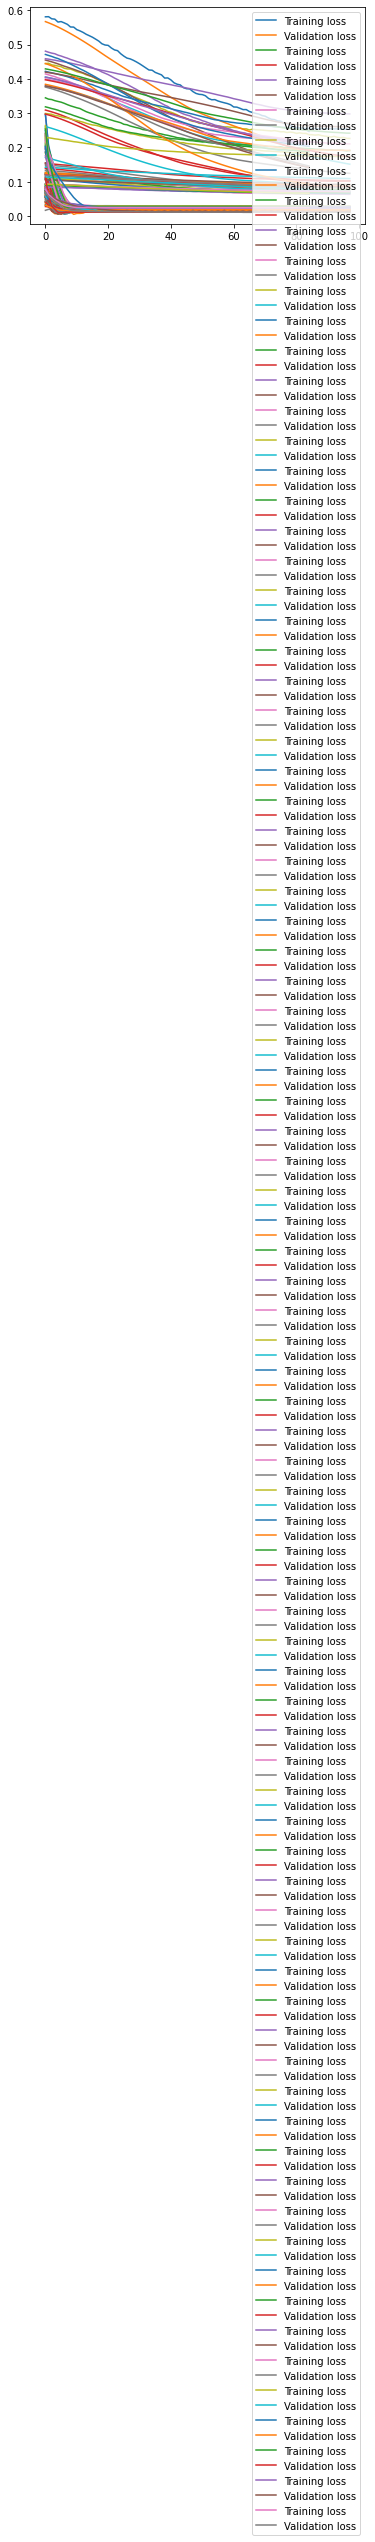

In [14]:
def _model(units,activationDense,dropout1,optimizer):
    model = Sequential()
    model.add(Dense(units=units, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(rate=dropout1))
    model.add(Dense(X_train.shape[2],activation=activationDense))
    model.compile(optimizer=optimizer, loss='mae')
    model.summary()
    
    return model

sequences = ["1h","3h","6h","12h","1d", "3d", "7d"]
X_trains = [X_train1h,X_train3h, X_train6h, X_train12h,X_train1d,X_train3d, X_train7d]
y_trains= [y_train1h,y_train3h, y_train6h,y_train12h,y_train1d,y_train3d, y_train7d]
activationsDense = ['tanh','sigmoid']
optimizers = ['adam','adadelta','adamax']
list_validationSplit = [0.1,0.2]
list_dropout1 =  np.random.uniform(0.1,0.8,5)   #generació de llista de 10 learning rate (entre 0.01 i 0.2)
list_units = np.random.randint(6,high=100, size=5) #generació de llista de 10 iteracions (entre 20 i 500)
list_epochs = np.random.randint(5,high=100, size=5) #generació de llista de 10 iteracions (entre 20 i 500)  
list_batchsize = np.random.randint(6,high=64, size=5) #generació de llista de 10 iteracions (entre 20 i 500)    

list_results = pd.DataFrame()

for X_train, y_train,sequence in zip(X_trains,y_trains,sequences):
    for optimizer in optimizers:
        #for activation in activations:
            for activationDense in activationsDense:
                for units,epochs,batchsize,dropout1,validationsplit in zip(list_units,list_epochs,list_batchsize,list_dropout1,list_validationSplit): 
                    start = time()
                    print("###########################\n")
                    print("MODEL: ", "DNN")
                    print('sequence: ',sequence)
                    print('units: ',units)
                    print('dropout1: ',dropout1)
                    print('optimizer:',optimizer)
                    #print('activation:',activation)
                    print('activationDense:',activationDense)
                    print('epochs:',epochs)
                    print('batchsize:',batchsize)
                    print('validation_split:',validationsplit)

                    model = _model(units,activationDense,dropout1,optimizer)
                    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batchsize, validation_split=validationsplit, shuffle=False)
                    end = time()
                    totalTime = end-start
                    print ('Execution time: ',totalTime)

                    import matplotlib.pyplot as plt
                    plt.plot(history.history['loss'], label='Training loss')
                    plt.plot(history.history['val_loss'], label='Validation loss')
                    plt.legend();

                    X_train_pred = model.predict(X_train, verbose=0)

                    mae,rmse,mse = evaluate_prediction(X_train_pred, X_train,"DNN")

                    print('Train RMSE: %.3f' % rmse);
                    print('Train MSE: %.3f' % mse);
                    print('Train MAE: %.3f' % mae);

                    result = pd.DataFrame({
                                           #'activation':[activation],
                                           'model':["DNN"],
                                           'sequence':[sequence],
                                           'activationDense':[activationDense],
                                           'optimizer':[optimizer],
                                           'dropout1':[dropout1],
                                           'units':[units],
                                           'epochs':[epochs],
                                           'batchsize':[batchsize],
                                           'validation_split':[validationsplit],

                                           'RMSE':[rmse],
                                           'MSE':[mse],
                                           'MAE':[mae],                            
                                           'Time':[totalTime]})
                    list_results = list_results.append(result) 

In [15]:
list_results.to_csv("resultats-cerca-optim-dnn.csv")

In [16]:
list_results.head(20)

,model,sequence,activationDense,optimizer,dropout1,units,epochs,batchsize,validation_split,RMSE,MSE,MAE,Time
0,DNN,1h,tanh,adam,0.795696,97,98,43,0.1,0.030132,0.000908,0.018967,17.585649
0,DNN,1h,tanh,adam,0.779406,22,85,23,0.2,0.034743,0.001207,0.022050,19.619283
0,DNN,1h,sigmoid,adam,0.795696,97,98,43,0.1,0.033080,0.001094,0.020072,16.172646
0,DNN,1h,sigmoid,adam,0.779406,22,85,23,0.2,0.043117,0.001859,0.026169,18.853198
0,DNN,1h,tanh,adadelta,0.795696,97,98,43,0.1,0.177944,0.031664,0.175224,15.930931
0,DNN,1h,tanh,adadelta,0.779406,22,85,23,0.2,0.199517,0.039807,0.195685,18.863140
0,DNN,1h,sigmoid,adadelta,0.795696,97,98,43,0.1,0.081038,0.006567,0.073569,16.355124
0,DNN,1h,sigmoid,adadelta,0.779406,22,85,23,0.2,0.071137,0.005060,0.063235,18.562690
0,DNN,1h,tanh,adamax,0.795696,97,98,43,0.1,0.026339,0.000694,0.016100,16.440959
0,DNN,1h,tanh,adamax,0.779406,22,85,23,0.2,0.028083,0.000789,0.018252,18.201188


In [17]:
list_results.sort_values(by=['RMSE', 'sequence'])

,model,sequence,activationDense,optimizer,dropout1,units,epochs,batchsize,validation_split,RMSE,MSE,MAE,Time
0,DNN,1h,sigmoid,adamax,0.779406,22,85,23,0.2,0.022632,0.000512,0.014066,18.778049
0,DNN,1h,sigmoid,adamax,0.795696,97,98,43,0.1,0.025958,0.000674,0.016329,16.130773
0,DNN,1h,tanh,adamax,0.795696,97,98,43,0.1,0.026339,0.000694,0.016100,16.440959
0,DNN,1h,tanh,adamax,0.779406,22,85,23,0.2,0.028083,0.000789,0.018252,18.201188
0,DNN,1h,tanh,adam,0.795696,97,98,43,0.1,0.030132,0.000908,0.018967,17.585649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,DNN,1h,tanh,adadelta,0.795696,97,98,43,0.1,0.177944,0.031664,0.175224,15.930931
0,DNN,1h,tanh,adadelta,0.779406,22,85,23,0.2,0.199517,0.039807,0.195685,18.863140
0,DNN,7d,tanh,adadelta,0.795696,97,98,43,0.1,0.204984,0.042018,0.202476,314.883570
0,DNN,12h,tanh,adadelta,0.795696,97,98,43,0.1,0.217763,0.047421,0.215512,44.823819
